# ノートブック06: サポートベクターマシン (SVM) とカーネル法

## 学習目標

このノートブックでは、サポートベクターマシン (SVM) とカーネル法について学びます:

1. **SVMの基礎**
   - マージン最大化の原理
   - サポートベクターの役割
   - ハードマージンとソフトマージン

2. **線形SVM**
   - 線形分離可能なデータへの適用
   - Cパラメータの意味と調整

3. **カーネル法**
   - カーネルトリックの原理
   - RBF (Radial Basis Function) カーネル
   - 多項式カーネル
   - シグモイドカーネル

4. **非線形分類**
   - make_moons、make_circlesデータセット
   - カーネル別の決定境界の可視化

5. **ハイパーパラメータチューニング**
   - GridSearchCVによるC、gammaの最適化
   - 過学習と未学習のバランス

6. **実践例**
   - 乳がん診断データセット
   - 他の分類器との比較

---

## セットアップ

In [1]:
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC, LinearSVC
from sklearn.datasets import make_classification, make_moons, make_circles, load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings

warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('whitegrid')

# ランダムシード固定
np.random.seed(42)

print("Setup complete!")

Setup complete!


---

## 1. SVMの基礎: マージン最大化

### SVMの核心アイデア

サポートベクターマシン (SVM) は、**マージンを最大化**することで分類境界を決定します。

- **マージン**: 決定境界と最も近いデータポイントとの距離
- **サポートベクター**: マージン上にある重要なデータポイント
- **目的**: マージンを最大化することで、汎化性能を向上

### 線形SVMのデモ

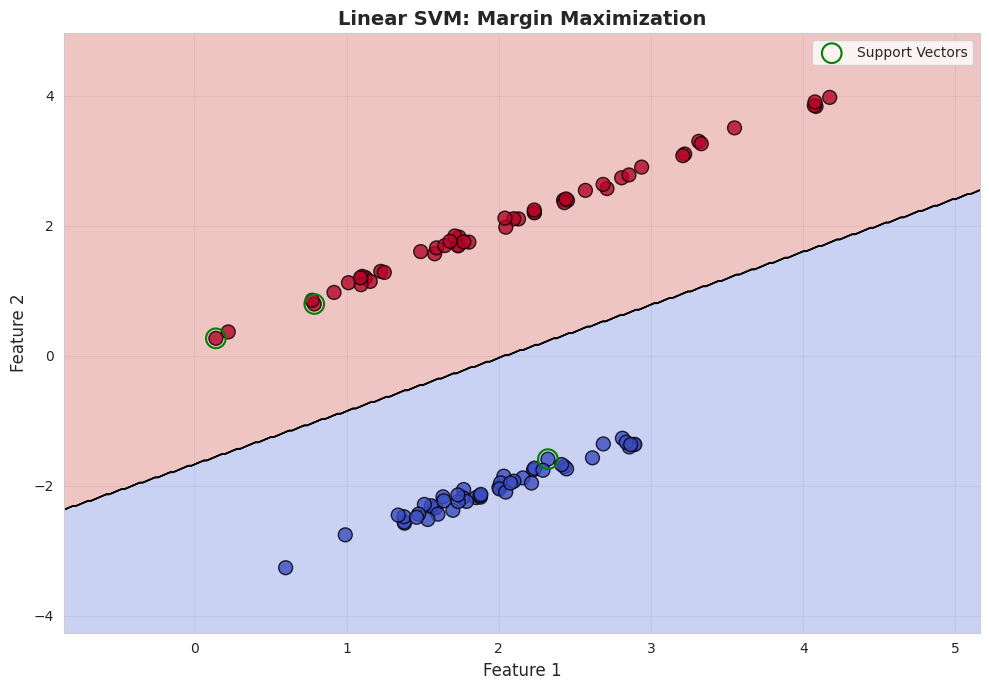

Number of support vectors: 3
Total data points: 100
Percentage of support vectors: 3.0%


In [2]:
# 線形分離可能なデータの生成
X, y = make_classification(
    n_samples=100,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    n_clusters_per_class=1,
    class_sep=2.0,
    random_state=42
)

# 線形SVMの訓練
svm_linear = SVC(kernel='linear', C=1.0)
svm_linear.fit(X, y)

# 決定境界とマージンの可視化
def plot_svm_decision_boundary(model, X, y, title='SVM Decision Boundary'):
    plt.figure(figsize=(10, 7))
    
    # メッシュグリッドの作成
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # 予測
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # 決定境界のプロット
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.contour(xx, yy, Z, colors='k', linewidths=0.5)
    
    # データポイントのプロット
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', 
                edgecolors='k', s=100, alpha=0.8)
    
    # サポートベクターの強調表示
    if hasattr(model, 'support_vectors_'):
        plt.scatter(model.support_vectors_[:, 0], 
                    model.support_vectors_[:, 1],
                    s=200, linewidth=1.5, facecolors='none', 
                    edgecolors='green', label='Support Vectors')
    
    plt.xlabel('Feature 1', fontsize=12)
    plt.ylabel('Feature 2', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_svm_decision_boundary(svm_linear, X, y, 'Linear SVM: Margin Maximization')

print(f"Number of support vectors: {len(svm_linear.support_vectors_)}")
print(f"Total data points: {len(X)}")
print(f"Percentage of support vectors: {len(svm_linear.support_vectors_) / len(X) * 100:.1f}%")

### 観察ポイント

1. **サポートベクター (緑の円)**: 決定境界に最も近いポイント。これらのポイントだけがモデルの決定に影響
2. **マージン**: サポートベクターと決定境界の距離が最大化されている
3. **汎化性能**: マージンが大きいほど、未知のデータに対する性能が向上

---

## 2. Cパラメータ: ソフトマージンSVM

### Cパラメータの役割

実際のデータは完全には線形分離できないことが多いです。Cパラメータは、**誤分類の許容度**を制御します:

- **C が大きい**: 誤分類を許さない → マージンが小さくなり、過学習のリスク
- **C が小さい**: 誤分類を許容 → マージンが大きくなり、未学習のリスク

### Cの影響を可視化

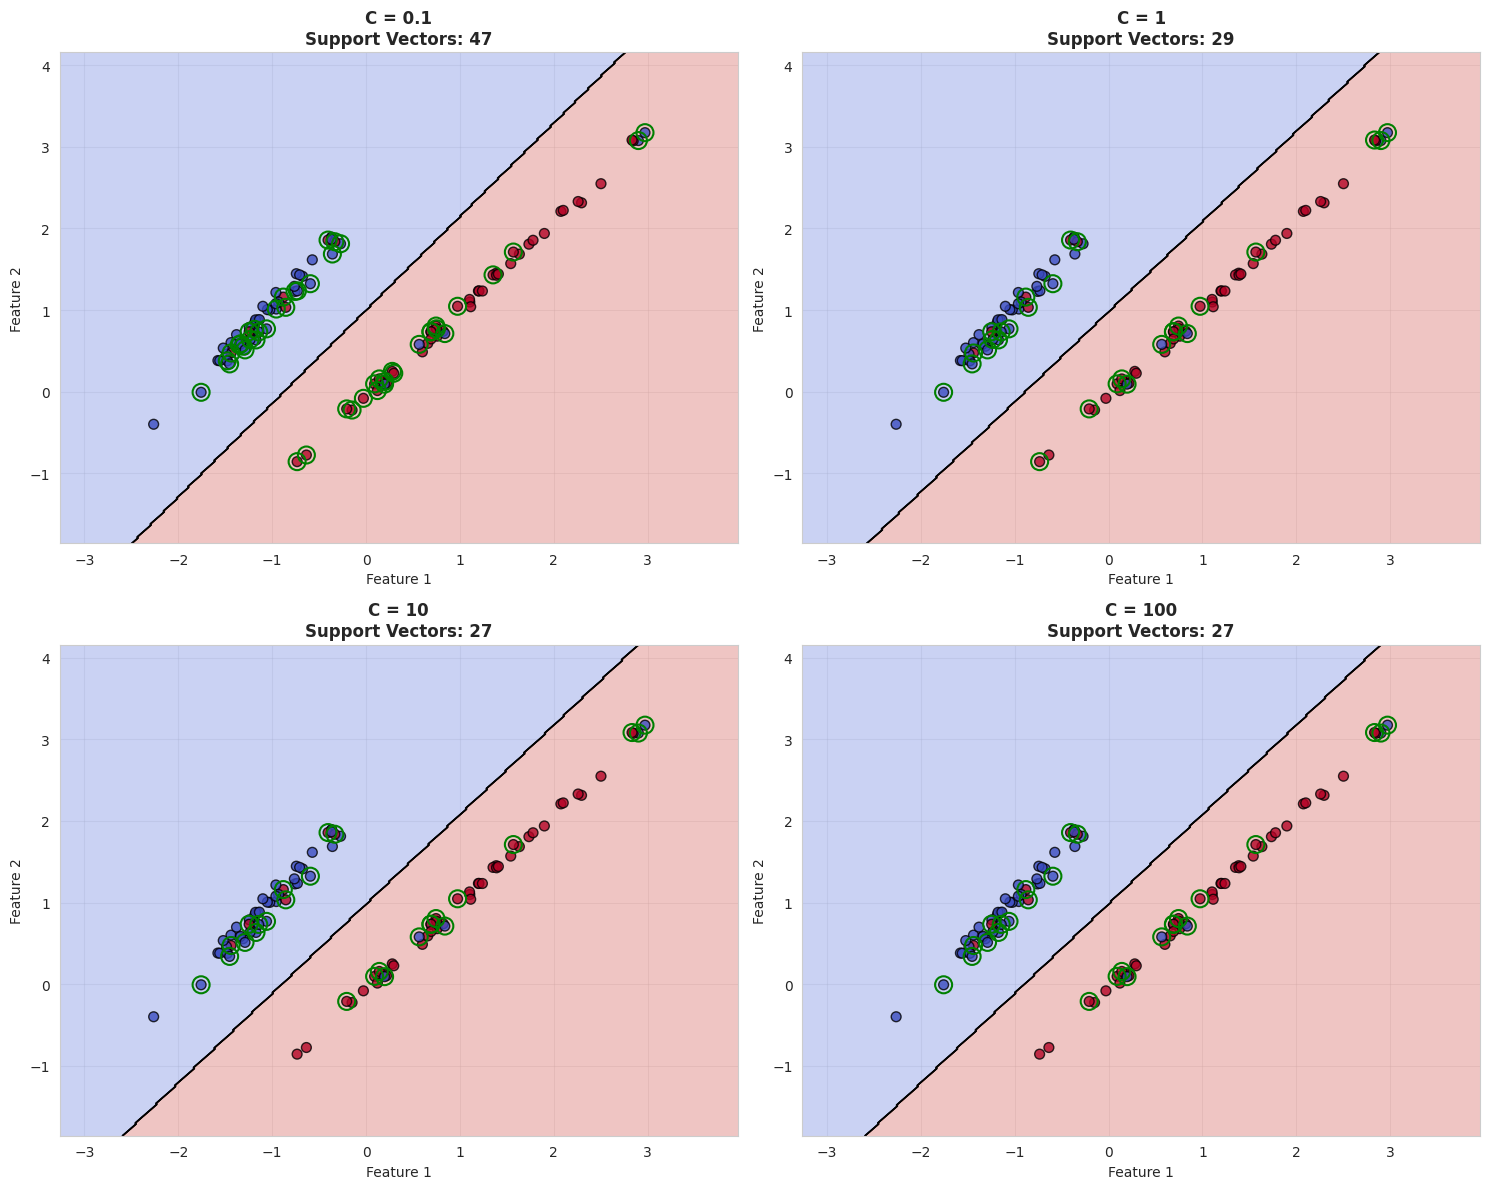


C parameter comparison:
- Small C (0.1, 1): Wider margin, more support vectors, allows misclassification
- Large C (10, 100): Narrower margin, fewer support vectors, minimizes misclassification


In [3]:
# ノイズのあるデータの生成
X_noisy, y_noisy = make_classification(
    n_samples=100,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    n_clusters_per_class=1,
    class_sep=1.0,
    flip_y=0.1,  # ノイズ追加
    random_state=42
)

# 異なるCの値でSVMを訓練
C_values = [0.1, 1, 10, 100]

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, C in enumerate(C_values):
    svm = SVC(kernel='linear', C=C)
    svm.fit(X_noisy, y_noisy)
    
    # メッシュグリッドの作成
    h = 0.02
    x_min, x_max = X_noisy[:, 0].min() - 1, X_noisy[:, 0].max() + 1
    y_min, y_max = X_noisy[:, 1].min() - 1, X_noisy[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axes[idx].contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    axes[idx].contour(xx, yy, Z, colors='k', linewidths=0.5)
    axes[idx].scatter(X_noisy[:, 0], X_noisy[:, 1], c=y_noisy, 
                      cmap='coolwarm', edgecolors='k', s=50, alpha=0.8)
    axes[idx].scatter(svm.support_vectors_[:, 0], 
                      svm.support_vectors_[:, 1],
                      s=150, linewidth=1.5, facecolors='none', 
                      edgecolors='green')
    
    axes[idx].set_xlabel('Feature 1', fontsize=10)
    axes[idx].set_ylabel('Feature 2', fontsize=10)
    axes[idx].set_title(f'C = {C}\nSupport Vectors: {len(svm.support_vectors_)}',
                        fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nC parameter comparison:")
print("- Small C (0.1, 1): Wider margin, more support vectors, allows misclassification")
print("- Large C (10, 100): Narrower margin, fewer support vectors, minimizes misclassification")

---

## 3. カーネル法: 非線形分類への拡張

### カーネルトリックとは?

線形分離できないデータに対して、SVMは**カーネルトリック**を使用します:

1. データを高次元空間に写像
2. 高次元空間で線形分離を実行
3. 元の空間に戻すと非線形境界になる

### 主なカーネル関数

1. **線形カーネル**: $K(x, x') = x \cdot x'$
2. **RBFカーネル (Gaussian)**: $K(x, x') = \exp(-\gamma \|x - x'\|^2)$
3. **多項式カーネル**: $K(x, x') = (\gamma x \cdot x' + r)^d$
4. **シグモイドカーネル**: $K(x, x') = \tanh(\gamma x \cdot x' + r)$

### 非線形データでのカーネル比較

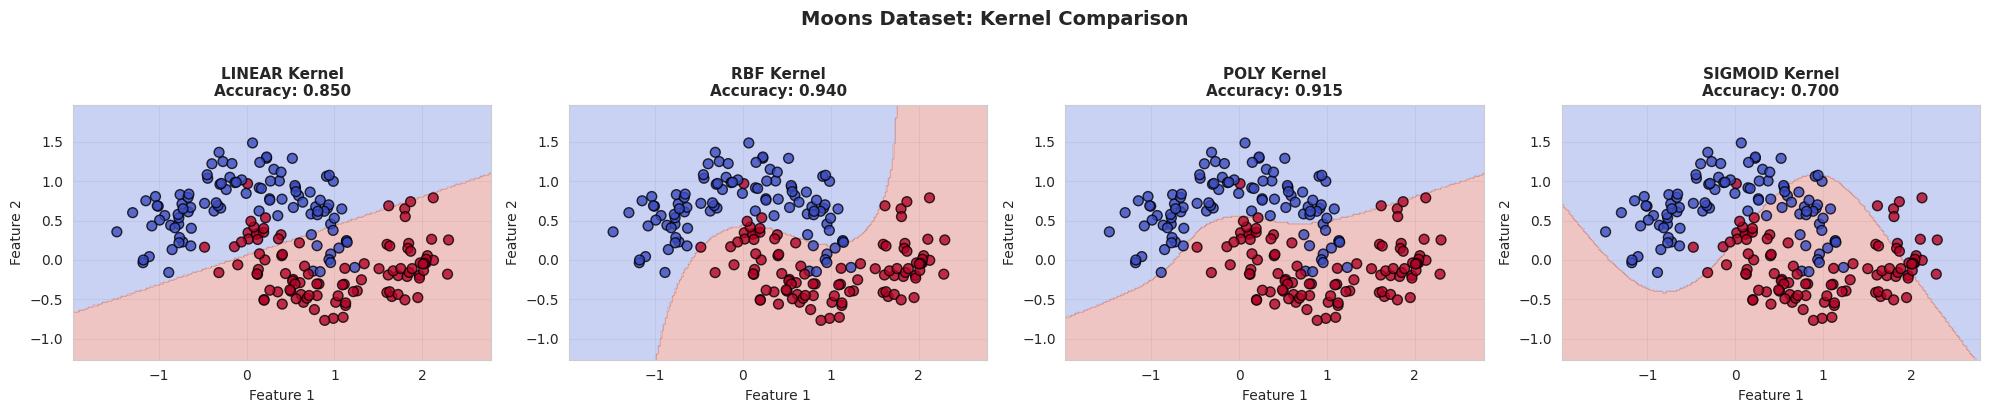

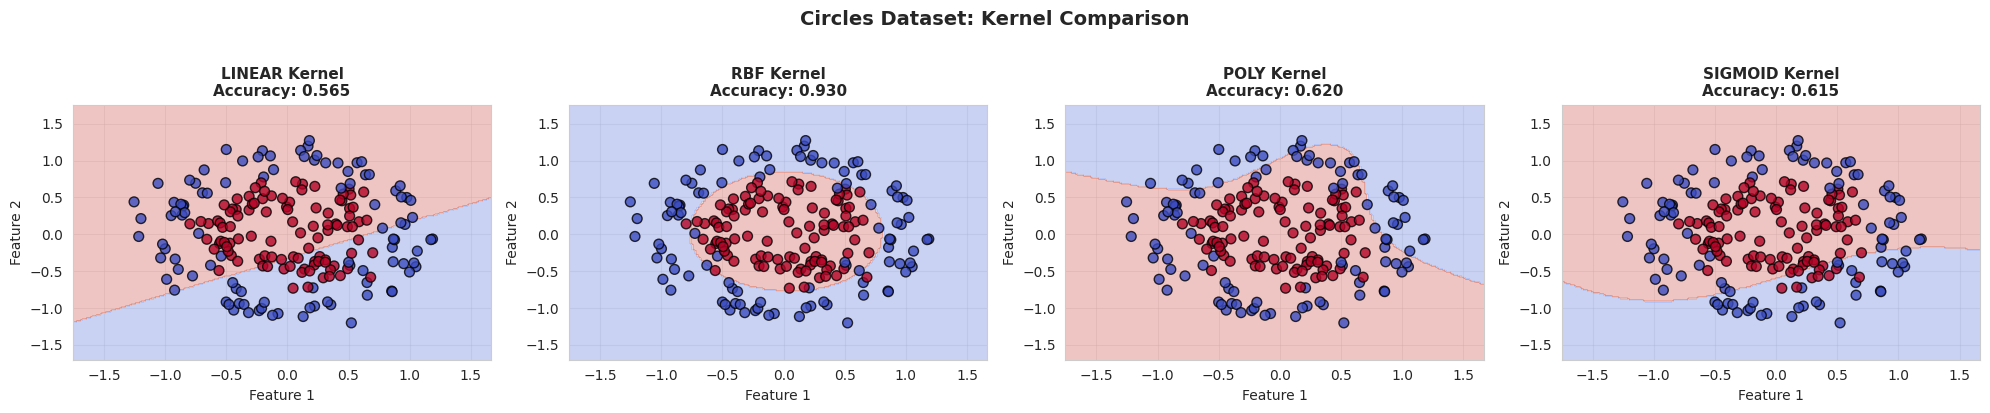


Kernel Performance Summary:
- Linear: Poor for non-linear data
- RBF: Best for most non-linear patterns
- Polynomial: Good for specific curved patterns
- Sigmoid: Similar to neural network activation


In [4]:
# 2つの非線形データセットを生成
X_moons, y_moons = make_moons(n_samples=200, noise=0.2, random_state=42)
X_circles, y_circles = make_circles(n_samples=200, noise=0.15, factor=0.5, random_state=42)

datasets = [
    ('Moons Dataset', X_moons, y_moons),
    ('Circles Dataset', X_circles, y_circles)
]

kernels = ['linear', 'rbf', 'poly', 'sigmoid']

for dataset_name, X_data, y_data in datasets:
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    
    for idx, kernel in enumerate(kernels):
        # SVMモデルの訓練
        if kernel == 'poly':
            svm = SVC(kernel=kernel, degree=3, C=1.0)
        else:
            svm = SVC(kernel=kernel, C=1.0, gamma='auto')
        
        svm.fit(X_data, y_data)
        
        # メッシュグリッド
        h = 0.02
        x_min, x_max = X_data[:, 0].min() - 0.5, X_data[:, 0].max() + 0.5
        y_min, y_max = X_data[:, 1].min() - 0.5, X_data[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        
        Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        axes[idx].contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
        axes[idx].scatter(X_data[:, 0], X_data[:, 1], c=y_data, 
                          cmap='coolwarm', edgecolors='k', s=50, alpha=0.8)
        
        accuracy = svm.score(X_data, y_data)
        axes[idx].set_xlabel('Feature 1', fontsize=10)
        axes[idx].set_ylabel('Feature 2', fontsize=10)
        axes[idx].set_title(f'{kernel.upper()} Kernel\nAccuracy: {accuracy:.3f}',
                            fontsize=11, fontweight='bold')
        axes[idx].grid(True, alpha=0.3)
    
    fig.suptitle(f'{dataset_name}: Kernel Comparison', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

print("\nKernel Performance Summary:")
print("- Linear: Poor for non-linear data")
print("- RBF: Best for most non-linear patterns")
print("- Polynomial: Good for specific curved patterns")
print("- Sigmoid: Similar to neural network activation")

### 観察ポイント

1. **Moons Dataset**: RBFと多項式カーネルが優れた性能
2. **Circles Dataset**: RBFカーネルが明らかに最適
3. **線形カーネル**: 非線形パターンには不十分

---

## 4. RBFカーネルのgammaパラメータ

### gammaパラメータの役割

RBFカーネルでは、gammaパラメータが**決定境界の複雑さ**を制御します:

- **gamma が大きい**: 各サンプルの影響範囲が狭い → 複雑な境界 → 過学習のリスク
- **gamma が小さい**: 各サンプルの影響範囲が広い → 滑らかな境界 → 未学習のリスク

### gammaの影響を可視化

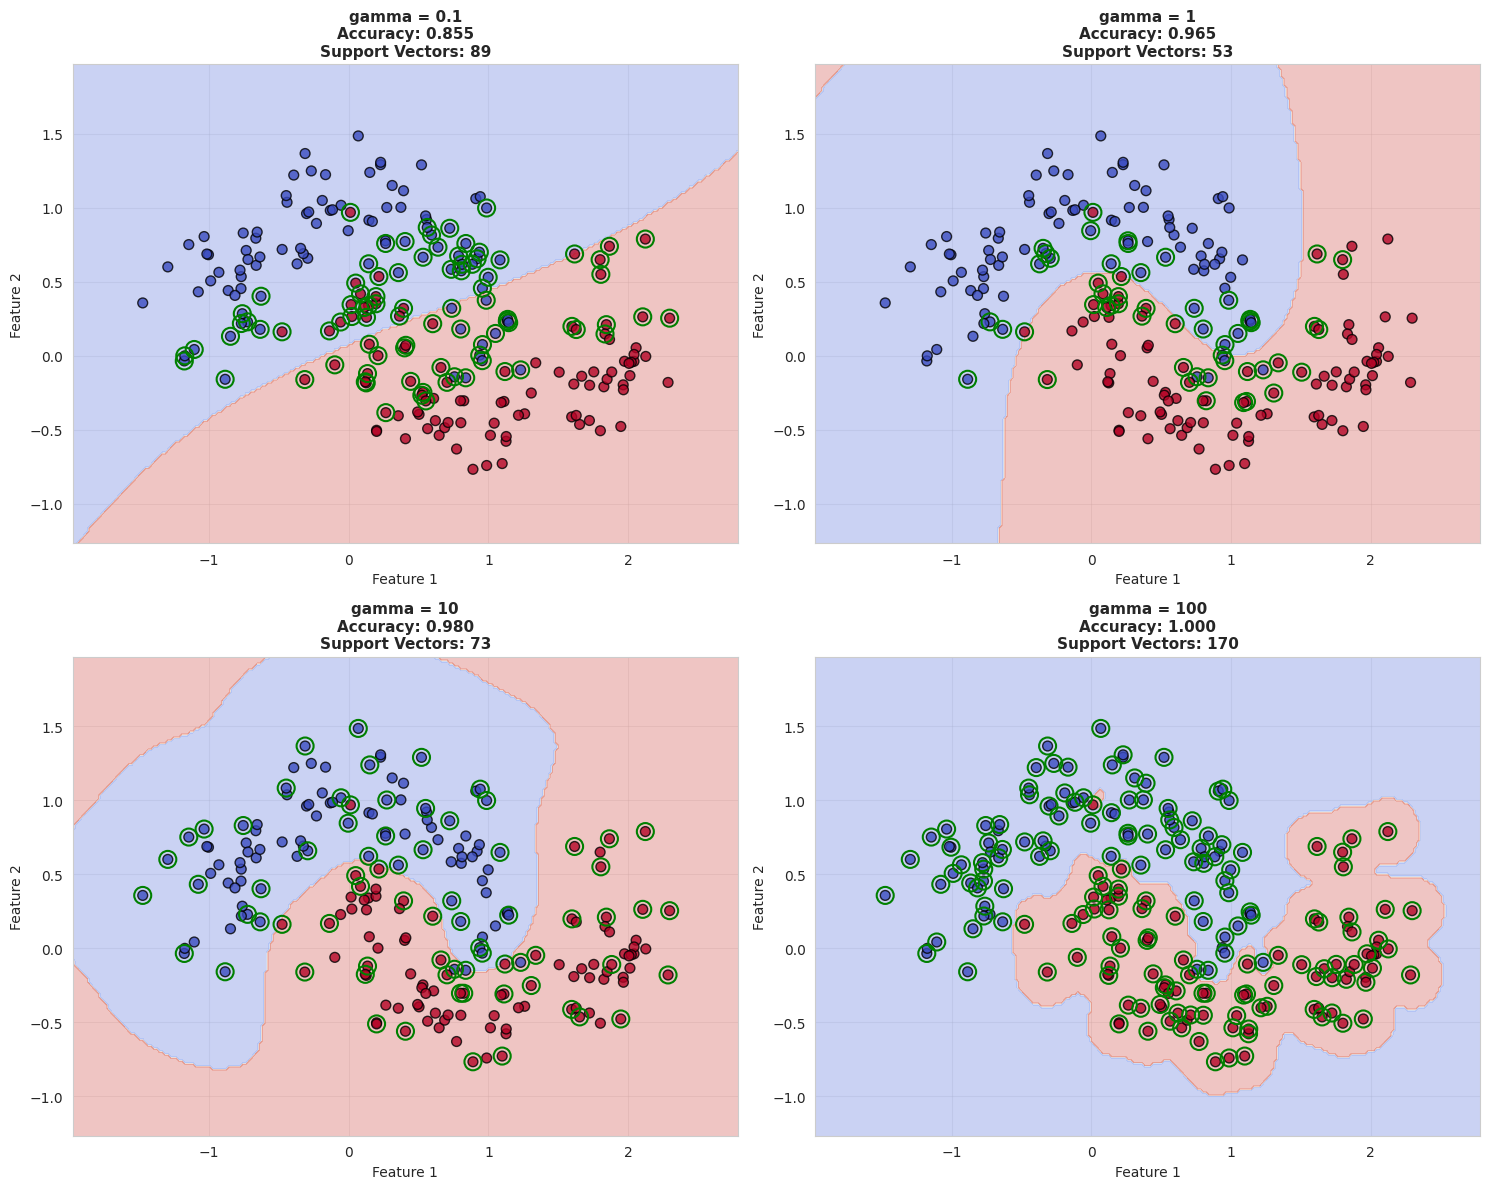


gamma parameter effects:
- Small gamma (0.1): Smooth decision boundary, may underfit
- Medium gamma (1): Balanced complexity
- Large gamma (10, 100): Complex boundary, may overfit


In [5]:
# Moonsデータセットを使用
X_moons, y_moons = make_moons(n_samples=200, noise=0.2, random_state=42)

# 異なるgammaの値でSVMを訓練
gamma_values = [0.1, 1, 10, 100]

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, gamma in enumerate(gamma_values):
    svm = SVC(kernel='rbf', C=1.0, gamma=gamma)
    svm.fit(X_moons, y_moons)
    
    # メッシュグリッド
    h = 0.02
    x_min, x_max = X_moons[:, 0].min() - 0.5, X_moons[:, 0].max() + 0.5
    y_min, y_max = X_moons[:, 1].min() - 0.5, X_moons[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axes[idx].contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    axes[idx].scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, 
                      cmap='coolwarm', edgecolors='k', s=50, alpha=0.8)
    axes[idx].scatter(svm.support_vectors_[:, 0], 
                      svm.support_vectors_[:, 1],
                      s=150, linewidth=1.5, facecolors='none', 
                      edgecolors='green')
    
    accuracy = svm.score(X_moons, y_moons)
    axes[idx].set_xlabel('Feature 1', fontsize=10)
    axes[idx].set_ylabel('Feature 2', fontsize=10)
    axes[idx].set_title(f'gamma = {gamma}\nAccuracy: {accuracy:.3f}\nSupport Vectors: {len(svm.support_vectors_)}',
                        fontsize=11, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\ngamma parameter effects:")
print("- Small gamma (0.1): Smooth decision boundary, may underfit")
print("- Medium gamma (1): Balanced complexity")
print("- Large gamma (10, 100): Complex boundary, may overfit")

---

## 5. ハイパーパラメータチューニング: GridSearchCV

最適なC、gamma、kernelの組み合わせを見つけるために、GridSearchCVを使用します。

Starting Grid Search...
Fitting 5 folds for each of 60 candidates, totalling 300 fits



GRID SEARCH RESULTS

Best Parameters: {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
Best CV Score: 0.9643
Test Set Accuracy: 0.9500

Top 5 Parameter Combinations:
                                      params  mean_test_score  std_test_score  \
27    {'C': 1, 'gamma': 10, 'kernel': 'rbf'}         0.964286        0.022588   
39    {'C': 10, 'gamma': 1, 'kernel': 'rbf'}         0.964286        0.022588   
57  {'C': 100, 'gamma': 10, 'kernel': 'rbf'}         0.964286        0.039123   
12  {'C': 0.1, 'gamma': 10, 'kernel': 'rbf'}         0.957143        0.026726   
24     {'C': 1, 'gamma': 1, 'kernel': 'rbf'}         0.957143        0.026726   

    rank_test_score  
27                1  
39                1  
57                1  
12                4  
24                4  


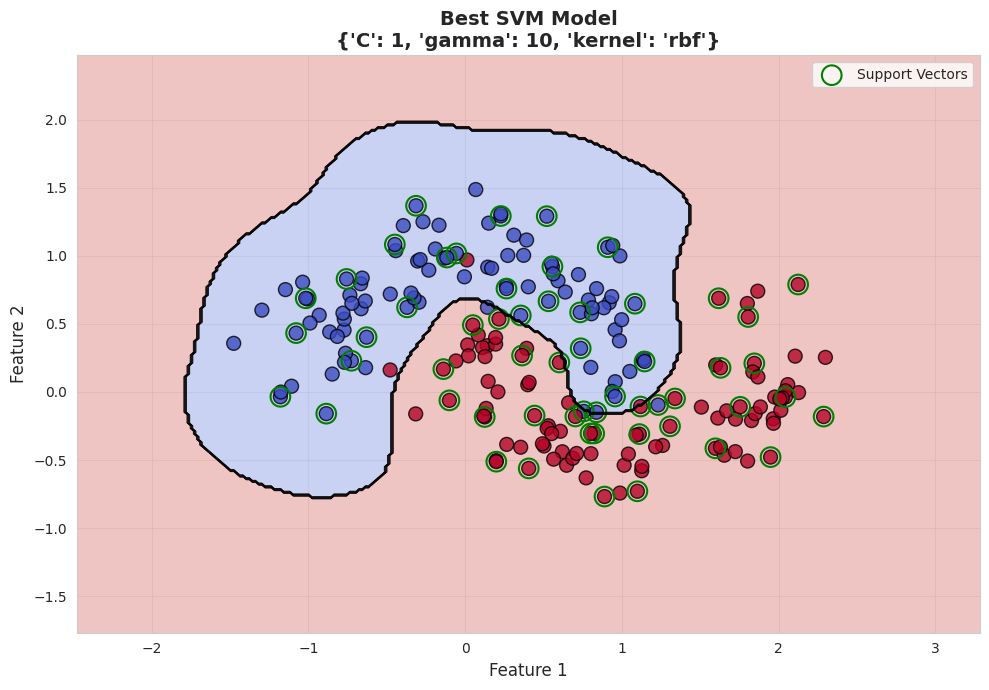

In [6]:
# データの分割
X_train, X_test, y_train, y_test = train_test_split(
    X_moons, y_moons, test_size=0.3, random_state=42
)

# パラメータグリッドの定義
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 10],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

# GridSearchCVの実行
grid_search = GridSearchCV(
    SVC(),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

print("\n" + "="*60)
print("GRID SEARCH RESULTS")
print("="*60)
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV Score: {grid_search.best_score_:.4f}")
print(f"Test Set Accuracy: {grid_search.score(X_test, y_test):.4f}")

# Top 5の結果を表示
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values('rank_test_score')
print("\nTop 5 Parameter Combinations:")
print(results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].head())

# 最適モデルの可視化
best_model = grid_search.best_estimator_
plot_svm_decision_boundary(best_model, X_moons, y_moons, 
                           f'Best SVM Model\n{grid_search.best_params_}')

### C vs gamma のヒートマップ

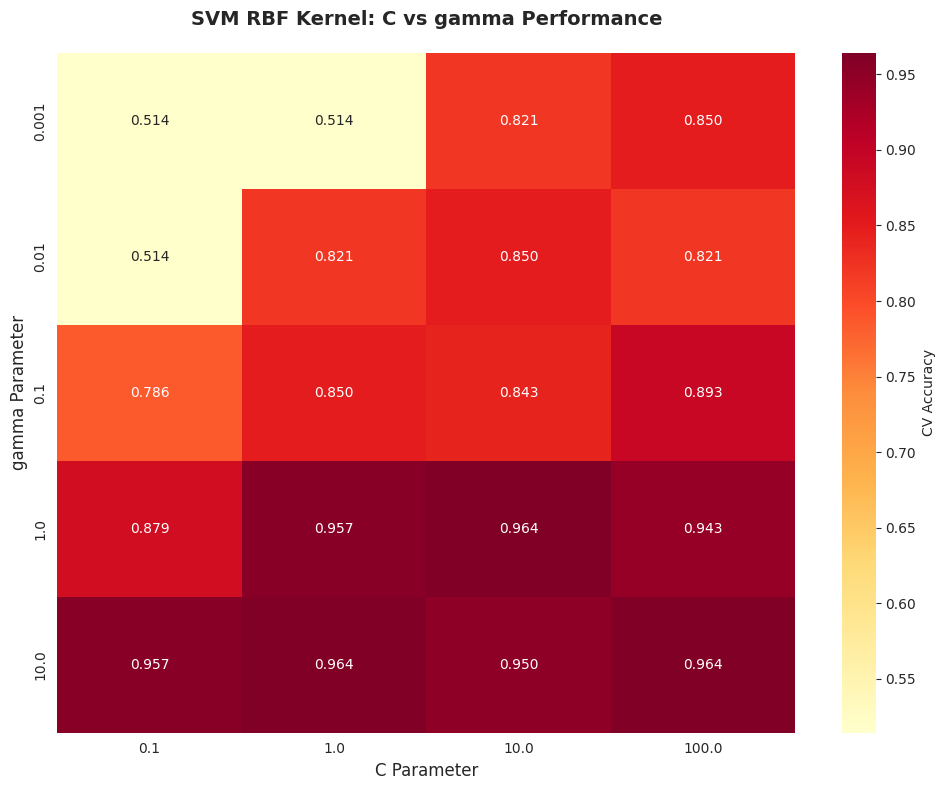


Heatmap Interpretation:
- Dark red regions: Best performance
- Light yellow regions: Poor performance
- Diagonal patterns often indicate overfitting/underfitting balance


In [7]:
# RBFカーネルに限定してヒートマップを作成
rbf_results = results_df[results_df['param_kernel'] == 'rbf'].copy()

# ピボットテーブルの作成
pivot_table = rbf_results.pivot_table(
    values='mean_test_score',
    index='param_gamma',
    columns='param_C'
)

# ヒートマップの可視化
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='YlOrRd', 
            cbar_kws={'label': 'CV Accuracy'})
plt.title('SVM RBF Kernel: C vs gamma Performance', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('C Parameter', fontsize=12)
plt.ylabel('gamma Parameter', fontsize=12)
plt.tight_layout()
plt.show()

print("\nHeatmap Interpretation:")
print("- Dark red regions: Best performance")
print("- Light yellow regions: Poor performance")
print("- Diagonal patterns often indicate overfitting/underfitting balance")

---

## 6. 実践例: 乳がん診断データセット

実際のデータセットを使って、SVMの性能を評価します。

In [8]:
# 乳がんデータセットの読み込み
cancer_data = load_breast_cancer()
X_cancer = cancer_data.data
y_cancer = cancer_data.target
feature_names = cancer_data.feature_names

print("Dataset Information:")
print(f"- Samples: {X_cancer.shape[0]}")
print(f"- Features: {X_cancer.shape[1]}")
print(f"- Classes: {len(np.unique(y_cancer))} (Malignant: {sum(y_cancer==0)}, Benign: {sum(y_cancer==1)})")
print(f"\nFeature names (first 10): {list(feature_names[:10])}")

Dataset Information:
- Samples: 569
- Features: 30
- Classes: 2 (Malignant: 212, Benign: 357)

Feature names (first 10): [np.str_('mean radius'), np.str_('mean texture'), np.str_('mean perimeter'), np.str_('mean area'), np.str_('mean smoothness'), np.str_('mean compactness'), np.str_('mean concavity'), np.str_('mean concave points'), np.str_('mean symmetry'), np.str_('mean fractal dimension')]


### データの前処理

In [9]:
# データの分割
X_train, X_test, y_train, y_test = train_test_split(
    X_cancer, y_cancer, test_size=0.2, random_state=42, stratify=y_cancer
)

# 標準化 (SVMでは重要!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data preprocessing complete.")
print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")

Data preprocessing complete.
Training set: (455, 30)
Test set: (114, 30)


### SVMモデルの訓練と評価

In [10]:
# 複数のカーネルでSVMを訓練
kernels = ['linear', 'rbf', 'poly']
svm_models = {}

print("Training SVM models with different kernels...\n")

for kernel in kernels:
    print(f"Training {kernel.upper()} kernel...")
    
    if kernel == 'poly':
        svm = SVC(kernel=kernel, degree=3, C=1.0, random_state=42)
    else:
        svm = SVC(kernel=kernel, C=1.0, random_state=42)
    
    svm.fit(X_train_scaled, y_train)
    svm_models[kernel] = svm
    
    # 評価
    train_acc = svm.score(X_train_scaled, y_train)
    test_acc = svm.score(X_test_scaled, y_test)
    cv_scores = cross_val_score(svm, X_train_scaled, y_train, cv=5)
    
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"  Support Vectors: {len(svm.support_vectors_)}\n")

Training SVM models with different kernels...

Training LINEAR kernel...
  Train Accuracy: 0.9912
  Test Accuracy: 0.9737
  CV Accuracy: 0.9670 (+/- 0.0139)
  Support Vectors: 32

Training RBF kernel...
  Train Accuracy: 0.9824
  Test Accuracy: 0.9825
  CV Accuracy: 0.9714 (+/- 0.0179)
  Support Vectors: 97

Training POLY kernel...
  Train Accuracy: 0.9165
  Test Accuracy: 0.9123
  CV Accuracy: 0.8967 (+/- 0.0215)
  Support Vectors: 145



### GridSearchCVで最適化

In [11]:
# パラメータグリッド
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

# GridSearchCV
grid_search = GridSearchCV(
    SVC(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("Starting Grid Search for optimal parameters...")
grid_search.fit(X_train_scaled, y_train)

print("\n" + "="*60)
print("OPTIMIZED SVM RESULTS")
print("="*60)
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV Score: {grid_search.best_score_:.4f}")
print(f"Test Set Accuracy: {grid_search.score(X_test_scaled, y_test):.4f}")

# 最適モデルで予測
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test_scaled)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Malignant', 'Benign']))

Starting Grid Search for optimal parameters...
Fitting 5 folds for each of 72 candidates, totalling 360 fits



OPTIMIZED SVM RESULTS

Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best CV Score: 0.9802
Test Set Accuracy: 0.9825

Classification Report:
              precision    recall  f1-score   support

   Malignant       0.98      0.98      0.98        42
      Benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



### 混同行列の可視化

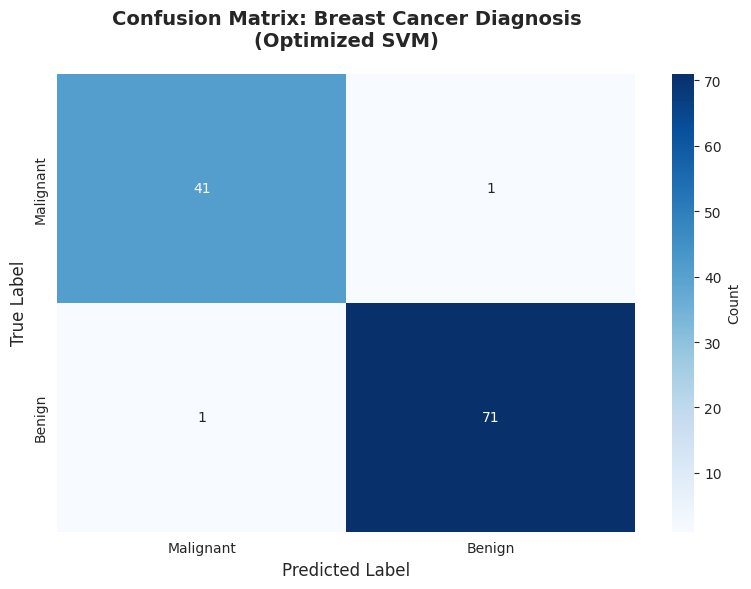


Error Analysis:
False Positives (Malignant predicted as Benign): 1
False Negatives (Benign predicted as Malignant): 1

Note: In medical diagnosis, minimizing false negatives is critical!


In [12]:
# 混同行列
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'],
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix: Breast Cancer Diagnosis\n(Optimized SVM)', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# エラー分析
false_positives = cm[0, 1]
false_negatives = cm[1, 0]
print(f"\nError Analysis:")
print(f"False Positives (Malignant predicted as Benign): {false_positives}")
print(f"False Negatives (Benign predicted as Malignant): {false_negatives}")
print(f"\nNote: In medical diagnosis, minimizing false negatives is critical!")

---

## 7. 他の分類器との比較

SVMの性能を、他の分類アルゴリズムと比較します。

In [13]:
# 複数のモデルを訓練
models = {
    'SVM (RBF)': SVC(kernel='rbf', C=10, gamma=0.001, random_state=42),
    'SVM (Linear)': SVC(kernel='linear', C=1.0, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=10000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
}

results = []

print("Comparing multiple classifiers...\n")

for name, model in models.items():
    # 訓練
    model.fit(X_train_scaled, y_train)
    
    # 評価
    train_acc = model.score(X_train_scaled, y_train)
    test_acc = model.score(X_test_scaled, y_test)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    
    results.append({
        'Model': name,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std()
    })
    
    print(f"{name}:")
    print(f"  Train: {train_acc:.4f} | Test: {test_acc:.4f} | CV: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# 結果をDataFrameに変換
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test Accuracy', ascending=False)

print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print(results_df.to_string(index=False))

Comparing multiple classifiers...

SVM (RBF):
  Train: 0.9802 | Test: 0.9825 | CV: 0.9736 (+/- 0.0164)


SVM (Linear):
  Train: 0.9912 | Test: 0.9737 | CV: 0.9670 (+/- 0.0139)
Logistic Regression:
  Train: 0.9890 | Test: 0.9825 | CV: 0.9802 (+/- 0.0128)
Decision Tree:
  Train: 1.0000 | Test: 0.9123 | CV: 0.9099 (+/- 0.0189)


Random Forest:
  Train: 1.0000 | Test: 0.9561 | CV: 0.9538 (+/- 0.0235)

MODEL COMPARISON SUMMARY
              Model  Train Accuracy  Test Accuracy  CV Mean   CV Std
          SVM (RBF)        0.980220       0.982456 0.973626 0.016447
Logistic Regression        0.989011       0.982456 0.980220 0.012815
       SVM (Linear)        0.991209       0.973684 0.967033 0.013900
      Random Forest        1.000000       0.956140 0.953846 0.023466
      Decision Tree        1.000000       0.912281 0.909890 0.018906


### 結果の可視化

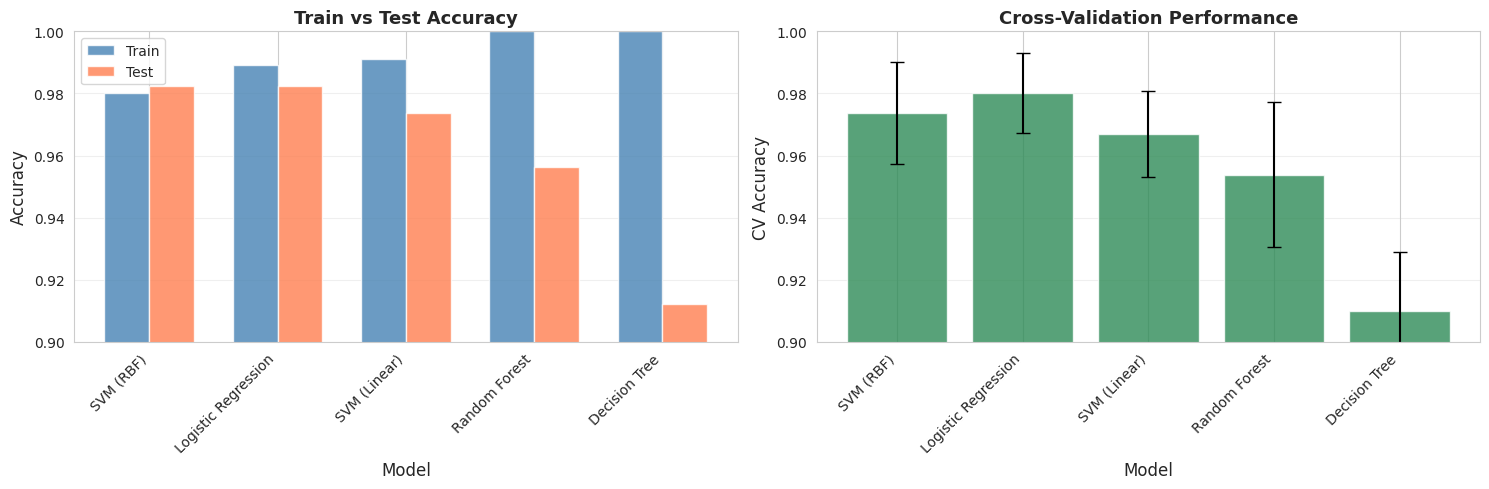

In [14]:
# バープロット
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Train vs Test Accuracy
x = np.arange(len(results_df))
width = 0.35

axes[0].bar(x - width/2, results_df['Train Accuracy'], width, 
            label='Train', alpha=0.8, color='steelblue')
axes[0].bar(x + width/2, results_df['Test Accuracy'], width, 
            label='Test', alpha=0.8, color='coral')
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Train vs Test Accuracy', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0.9, 1.0])

# CV Mean with Error Bars
axes[1].bar(x, results_df['CV Mean'], yerr=results_df['CV Std'], 
            alpha=0.8, color='seagreen', capsize=5)
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('CV Accuracy', fontsize=12)
axes[1].set_title('Cross-Validation Performance', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim([0.9, 1.0])

plt.tight_layout()
plt.show()

---

## まとめ

### SVMの主要ポイント

1. **マージン最大化**
   - SVMは決定境界とサポートベクターの距離を最大化
   - 汎化性能の向上につながる

2. **Cパラメータ**
   - 誤分類の許容度を制御
   - 大きいC → 過学習のリスク
   - 小さいC → 未学習のリスク

3. **カーネル法**
   - 線形分離できないデータを高次元空間で処理
   - RBFカーネルが最も汎用的
   - 多項式、シグモイドカーネルも状況により有効

4. **gammaパラメータ (RBF)**
   - 決定境界の複雑さを制御
   - 大きいgamma → 複雑な境界
   - 小さいgamma → 滑らかな境界

5. **前処理の重要性**
   - SVMは特徴量のスケールに敏感
   - StandardScalerによる標準化が必須

6. **ハイパーパラメータチューニング**
   - GridSearchCVで最適なC、gamma、kernelを探索
   - Cross-validationで汎化性能を評価

### SVMの長所と短所

**長所:**
- 高次元データに強い
- 非線形境界を効果的に学習
- 過学習に対して比較的ロバスト
- 少数のサンプルでも良好な性能

**短所:**
- 大規模データセットでは訓練が遅い (O(n²〜n³))
- ハイパーパラメータの調整が必要
- 確率的な予測が得られない (predict_probaはあるが近似)
- 解釈性が低い

### 実践的な使用ガイドライン

1. **データの前処理**: 必ずStandardScalerで標準化
2. **まず線形カーネルを試す**: データが線形分離可能か確認
3. **RBFカーネルを試す**: 非線形パターンがあれば
4. **GridSearchCVで最適化**: C、gammaを体系的に探索
5. **小〜中規模データに最適**: 大規模データではRandom ForestやGBDTを検討

---

## 練習問題

1. **カーネル比較**: Irisデータセットで、異なるカーネルの性能を比較してください
2. **パラメータ可視化**: C vs gammaのヒートマップを作成し、最適領域を特定してください
3. **医療診断**: 他の医療データセット (糖尿病、心臓病など) でSVMを適用してください
4. **非線形データ生成**: make_moonsやmake_circlesのノイズパラメータを変えて、SVMの性能を評価してください
5. **アンサンブル**: 複数のSVMモデル (異なるカーネル) を組み合わせて、性能向上を試みてください

---

**次のステップ**: ノートブック07で、k-NN (k近傍法) とクラスタリングを学びます!
